# COVID CNN

## Preparación de ambiente

### Carga de módulos

In [ ]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Data Visualization
# import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configuración del notebook
# cf.go_offline()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

### Preparación de carpetas

In [ ]:
if not os.path.exists("./models/"):
    os.mkdir("./models/")

### Validación de hardware

In [ ]:
print('Tensorflow version:', tf.__version__)
print('Is using GPU?', tf.config.list_physical_devices())

Tensorflow version: 2.19.0
Is using GPU? [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Wrangling

### Obtención de datos

In [ ]:
!git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301 (from 1)
Receiving objects: 100% (2301/2301), 1.31 GiB | 61.78 MiB/s, done.
Updating files: 100% (2295/2295), done.


### Establecimiento de rutas

In [ ]:
main_dir = "./datasets/Data"

In [ ]:
train_dir = os.path.join(main_dir, 'train')

In [ ]:
test_dir = os.path.join(main_dir, 'test')

#### Carpetas de entrenamiento

In [ ]:
train_covid_dir = os.path.join(train_dir, 'COVID19')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

#### Carpetas de validación

In [ ]:
test_covid_dir = os.path.join(test_dir, 'COVID19')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

In [ ]:
train_covid_dir

'./datasets/Data/train/COVID19'

### Tamaño de los conjuntos de datos

In [ ]:
train_covid_names = os.listdir(train_covid_dir)

In [ ]:
train_covid_names

In [ ]:
len(train_covid_names)

545

In [ ]:
train_normal_names = os.listdir(train_normal_dir)

In [ ]:
len(train_normal_names)

1266

In [ ]:
len(train_covid_names)+len(train_normal_names), len(train_covid_names) / (len(train_covid_names)+len(train_normal_names))

(1811, 0.3009387078961899)

In [ ]:
test_covid_names = os.listdir(test_covid_dir)

In [ ]:
len(test_covid_names)

167

In [ ]:
test_normal_names = os.listdir(test_normal_dir)

In [ ]:
len(test_normal_names)

317

In [ ]:
len(test_covid_names)+len(test_normal_names), len(test_covid_names) / (len(test_covid_names)+len(test_normal_names))

(484, 0.3450413223140496)

In [ ]:
train_covid_names[:5]

['COVID19(495).jpg',
 'COVID19(122).jpg',
 'COVID-19 (2).jpeg',
 'COVID19(554).jpg',
 'COVID19(424).jpg']

In [ ]:
train_covid_dir

'./datasets/Data/train/COVID19'

### Data visualization

In [ ]:
covid_pic = [os.path.join(train_covid_dir, filename) for filename in train_covid_names[:8]]
normal_pic = [os.path.join(train_normal_dir, filename) for filename in train_normal_names[:8]]

In [ ]:
full_pic = covid_pic+normal_pic

<Figure size 2400x2400 with 0 Axes>

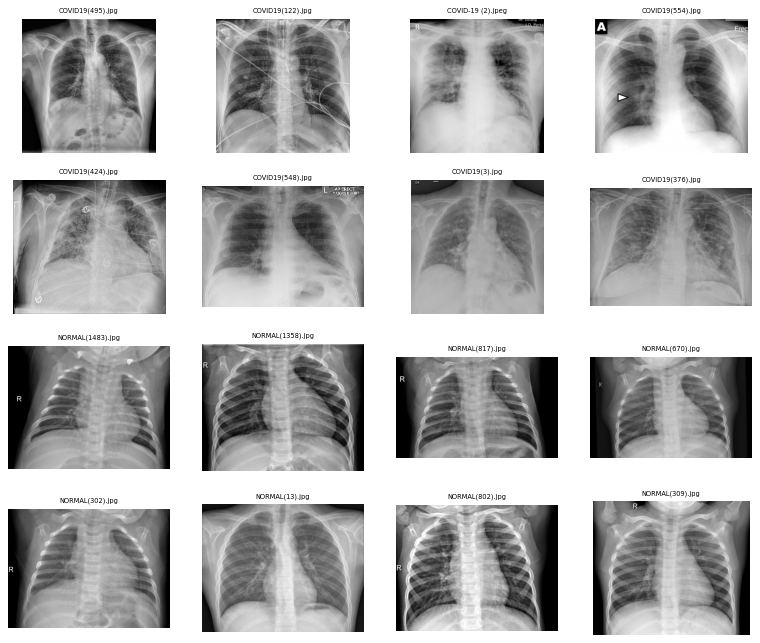

In [ ]:
ROWS = 4
COLS = 4
fig = plt.gcf()
fig.set_size_inches(24, 24)
plt.figure(figsize=(12, 10), dpi=80)
for i, img_path in enumerate(full_pic):
    data = img_path.split('/')[-1]
    sp = plt.subplot(ROWS, COLS, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    sp.set_title(data, fontsize=6)
    plt.imshow(img, cmap='gray')
plt.show()

### Generadores

In [ ]:
ImageDataGenerator?

In [ ]:
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [ ]:
dgen_validation = ImageDataGenerator(rescale=1./255)

In [ ]:
dgen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
TARGET_SIZE = (200, 200)
BATCH_SIZE = 32
CLASS_MODE = 'binary'

In [ ]:
train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)

Found 1449 images belonging to 2 classes.


In [ ]:
validation_generator = dgen_train.flow_from_directory(train_dir,
                                                      target_size=TARGET_SIZE,
                                                      subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE)

Found 362 images belonging to 2 classes.


In [ ]:
test_generator = dgen_test.flow_from_directory(test_dir,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE)

Found 484 images belonging to 2 classes.


#### Target

In [ ]:
train_generator.class_indices

{'COVID19': 0, 'NORMAL': 1}

#### Tamaño de los vectores de entrada

In [ ]:
train_generator.image_shape

(200, 200, 3)

## Modelado

### Establecimiento de base

In [ ]:
model = Sequential()

### Capas Convolucionales+Pooling

In [ ]:
model.add(Conv2D(32, (5,5), padding='same', activation='relu',
                input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

### Dropout

In [ ]:
Dropout?

In [ ]:
model.add(Dropout(0.2))

### Bloque convolucional

In [ ]:
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

### Capas densamente conectadas

In [ ]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 64)        0

### Parámetros de entrenamiento

In [ ]:
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Callbacks

#### Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

In [ ]:
early_stopping?

#### Checkpoints

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy'
                                               )

### Entrenamiento del modelo

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.8199

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 228s 5s/step - loss: 0.7773 - accuracy: 0.8199 - val_loss: 0.2059 - val_accuracy: 0.9282
Epoch 2/30
46/46 [==============================] - 223s 5s/step - loss: 0.2130 - accuracy: 0.9234 - val_loss: 0.1353 - val_accuracy: 0.9586
Epoch 3/30
46/46 [==============================] - 223s 5s/step - loss: 0.1810 - accuracy: 0.9358 - val_loss: 0.1740 - val_accuracy: 0.9558
Epoch 4/30
46/46 [==============================] - 223s 5s/step - loss: 0.1555 - accuracy: 0.9469 - val_loss: 0.1331 - val_accuracy: 0.9641
Epoch 5/30
46/46 [==============================] - 223s 5s/step - loss: 0.1320 - accuracy: 0.9531 - val_loss: 0.1289 - val_accuracy: 0.9558
Epoch 6/30
46/46 [==============================] - 222s 5s/step - loss: 0.1530 - accuracy: 0.9441 - val_loss: 0.1451 - val_accuracy: 0.9586
Epoch 7/30
46/46 [==============================] - 222s 5s/step - loss: 0.1025 - accuracy: 0.9641 - val_loss: 0.1130 - val_accuracy: 0.9641
Epoch 8/30
46/46 [======

## Evaluación de resultados

### Resultados de entrenamiento

In [ ]:
results = pd.DataFrame(data = zip(history.history["loss"], history.history["val_loss"], history.history["accuracy"], history.history["val_accuracy"]), columns=["loss", "val_loss", "accuracy", "val_accuracy"])

In [ ]:
results.iplot()

### Calificación de validate

In [ ]:
os.listdir("./models/")

In [ ]:
[x.split(".")[-2] for x in os.listdir("./models/")]

In [ ]:
max_acc = max([x.split(".")[-2] for x in os.listdir("./models/")])

In [ ]:
max_acc

In [ ]:
model = tf.keras.models.load_model(f'./models/model_0.{max_acc}.h5')

In [ ]:
model

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

### Prediciendo con una nueva imágen

In [ ]:
test_image = load_img('./datasets/Data/test/COVID19/COVID-19 (457).jpg', target_size=(200,200))

In [ ]:
test_image

In [ ]:
images = img_to_array(test_image)

In [ ]:
images.shape

In [ ]:
images

In [ ]:
images = np.expand_dims(images, axis=0)

In [ ]:
images

In [ ]:
images.shape

In [ ]:
prediction = model.predict(images)

In [ ]:
prediction

In [ ]:
train_generator.class_indices

In [ ]:
if prediction == 0:
    print('COVID Detected')
else:
    print('Report is Normal')

In [ ]:
model.save("cnn_covid.h5")